# First steps with sangria dataset

## Software requirements

- git clone https://gitlab.in2p3.fr/LISA/LDC
- pip install requirements.txt
- python setup.py install

## Downloading the sangria dataset

- https://lisa-ldc.lal.in2p3.fr/
- https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_v1.h5


In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import xarray as xr
from astropy import units as u

import ldc.io.hdf5 as hdfio
from ldc.lisa.noise import get_noise_model
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.common.series import TimeSeries, FrequencySeries, window
import ldc.waveform.fastGB as fastGB
from ldc.common.tools import compute_tdi_snr
from ldc.waveform.waveform import HpHc

In [2]:
DATAPATH = "/home/maude/data/LDC/sangria/1.6"
sangria_fn = DATAPATH+"/sangria_with_units.h5"
tdi_ts, tdi_descr = hdfio.load_array(sangria_fn, name="obs/tdi")
dt = int(1/(tdi_descr["sampling_frequency"]))

# Build timeseries and frequencyseries object for X,Y,Z
tdi_ts = xr.Dataset(dict([(k,TimeSeries(tdi_ts[k], dt=dt)) for k in ["X", "Y", "Z"]]))
tdi_fs = xr.Dataset(dict([(k,tdi_ts[k].ts.fft(win=window)) for k in ["X", "Y", "Z"]]))

## Looking at PSDs

[1e-05, None, 4e-22, 2e-19]

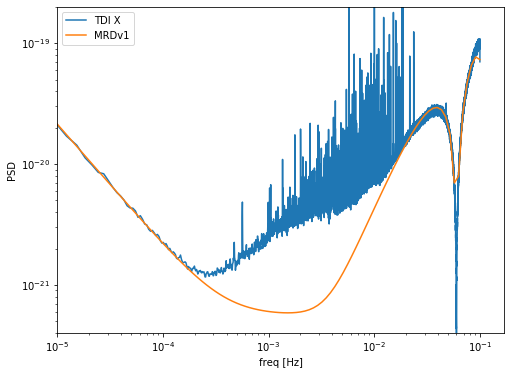

In [3]:
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
Npsd = Nmodel.psd()

plt.figure(figsize=(8,6))
f, psdX =  scipy.signal.welch(tdi_ts["X"], fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f, np.sqrt(psdX), label="TDI X")
plt.loglog(Nmodel.freq, np.sqrt(Npsd), label=noise_model, alpha=2)
plt.legend()
plt.xlabel("freq [Hz]")
plt.ylabel("PSD")
plt.axis([1e-5, None, 4e-22, 2e-19])

## Verification binary subtraction

Text(0.5, 0, 'freq [Hz]')

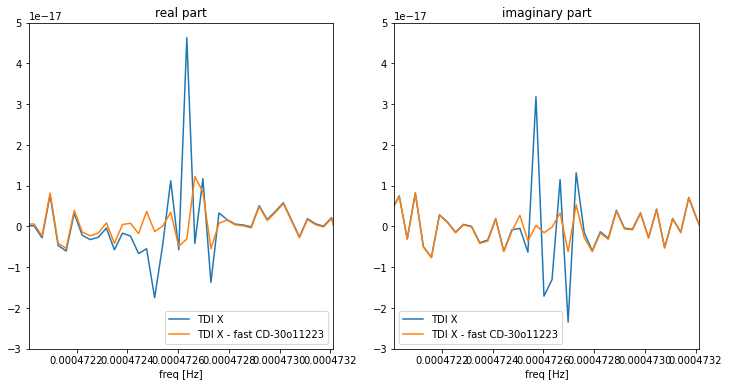

In [3]:
vgb, units = hdfio.load_array(sangria_fn, name="sky/vgb/cat")
GB = fastGB.FastGB(delta_t=dt, T=float(tdi_ts["X"].t[-1])) # in seconds
pGB = dict(zip(vgb.dtype.names, vgb[8])) # we take the source #8
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("real part")
plt.plot(tdi_fs["X"].f, tdi_fs["X"].real, label="TDI X")
plt.plot(Xs.f, (tdi_fs["X"][Xs.kmin:Xs.kmin+len(Xs)]-Xs.values).real, label="TDI X - fast "+pGB["Name"])
plt.axis([pGB["Frequency"]-6e-7, pGB["Frequency"]+6e-7, -3e-17, 5e-17])
plt.legend(loc="lower right")
plt.xlabel("freq [Hz]")
plt.subplot(122)
plt.title("imaginary part")
plt.plot(tdi_fs["X"].f, tdi_fs["X"].imag, label="TDI X")
plt.plot(Xs.f, (tdi_fs["X"].isel(f=slice(Xs.kmin, Xs.kmin+len(Xs)))-Xs.values).imag, label="TDI X - fast "+pGB["Name"])
plt.axis([pGB["Frequency"]-6e-7, pGB["Frequency"]+6e-7, -3e-17, 5e-17])
plt.legend(loc="lower left")
plt.xlabel("freq [Hz]")

## Computing the SNR of verification binaries

In [4]:
vgb, units = hdfio.load_array(sangria_fn, name="sky/vgb/cat")
GB = fastGB.FastGB(delta_t=dt, T=float(tdi_ts["X"].t[-1])) # in seconds
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
SNR2 = np.zeros((len(vgb), 2)) # snr square
for j,s in enumerate(vgb):
    pGB = dict(zip(vgb.dtype.names, s))
    Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')
    fmin, fmax = float(Xs.f[0]) , float(Xs.f[-1]+Xs.attrs['df'])
    source = dict({"X":Xs, "Y":Ys, "Z":Zs})
    SNR2[j,1] = compute_tdi_snr(source, Nmodel, data=tdi_fs, fmin=fmin, fmax=fmax)["tot2"]
    SNR2[j,0] = compute_tdi_snr(source, Nmodel)["tot2"] 

In [5]:
import pandas as pd
data = np.array([vgb["Name"], vgb["Frequency"], SNR2[:,0], SNR2[:,1]]).T
pd.DataFrame(data, columns=["Name", "f0", "fastGB", "TDI"])

,Name,f0,fastGB,TDI
0,V407_Vul,0.0035125,294.6125496245301,484.2974575149337
1,SDSS_J135154.46,0.002119003220884896,665.347499392389,666.367622627386
2,AM_CVn,0.00194414,9477.076421825454,9205.142948740131
3,SDSS_J190817.07+394036.4,0.0018421295017039697,907.4600948090265,918.902115593092
4,ZTF_J153932.16+502738.8,0.004821699107149872,3933.088238352361,3785.5588645923444
5,CR_Boo,0.00135962,6243.7161292937035,5947.1322310667765
6,SDSS_J093506.92+441107.0,0.00166667,238.67892254042565,205.38256126441743
7,PTF1_J191905.19+481506.2,0.0014843952944669167,35.84378401020733,52.398355491847205
8,CD-30o11223,0.000472612,2074.223695843639,2006.0219930714104
9,SDSS_J092345.59+302805.0,0.0005149728351829441,30.902479225131597,31.785595345584706


## MBHBs

This part should be updated with a MBHB fast approximation provided by the ldc toolbox

Text(0.5, 0, 'time [s]')

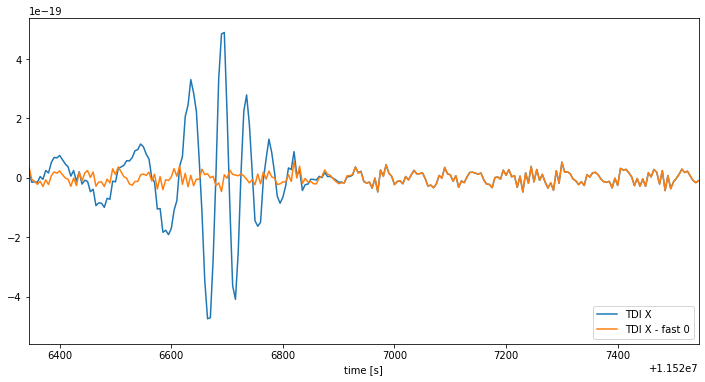

In [3]:
def semi_fast_tdi(config, pMBHB, t_max, dt):
    hphc = HpHc.type("MBHB-%d"%s_index, "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    orbits = Orbits.type(config)
    P = ProjectedStrain(orbits)    
    yArm = P.arm_response(0, t_max, dt, [hphc], tt_order=1)
    X = P.compute_tdi_x(np.arange(0, t_max, dt))
    return TimeSeries(X, dt=dt)

default_units = {'EclipticLatitude':'rad','EclipticLongitude':'rad',
         'PolarAngleOfSpin1':'rad','PolarAngleOfSpin2':'rad',
         'Spin1': '1','Spin2':'1',
         'Mass1':'Msun','Mass2':'Msun',
         'CoalescenceTime': 's','PhaseAtCoalescence':'rad',
         'InitialPolarAngleL':'rad','InitialAzimuthalAngleL':'rad',
         'Cadence': 's','Redshift': '1','Distance': 'Gpc',
         'ObservationDuration':'s'}

mbhb, units = hdfio.load_array(sangria_fn, name="sky/mbhb/cat")
if not units:
    units = default_units
config = hdfio.load_config(sangria_fn, name="obs/config")
s_index = 0
pMBHB = dict(zip(mbhb.dtype.names, mbhb[s_index]))
for k,v in pMBHB.items():
    pMBHB[k] *= u.Unit(units[k])

t_max = float(tdi_ts["X"].t[-1]+tdi_ts["X"].attrs["dt"])
Xs = semi_fast_tdi(config, pMBHB, t_max, dt)

plt.figure(figsize=(12,6))
plt.plot(tdi_ts["X"].t, tdi_ts["X"], label="TDI X")
plt.plot(Xs.t, (tdi_ts["X"]-Xs), label="TDI X - fast %d"%s_index)
plt.axis([pMBHB["CoalescenceTime"]-600, pMBHB["CoalescenceTime"]+600, None, None])
plt.legend(loc="lower right")
plt.xlabel("time [s]")

In [4]:
config["t_max"].unit

Unit("s")

In [11]:
def mldc_fast_tdi(pMBHB, t_max, dt):
    from GenerateFD_SignalTDIs import ComputeMBHBXYZ_FD
    from LISAhdf5 import ParsUnits
    hphc = HpHc.type("MBHB-%d"%s_index, "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    pMBHB["Cadence"] = dt
    pMBHB["ObservationDuration"] = t_max/2
    pu = ParsUnits(pars_i=pMBHB, units_i=hphc.info())
    fr, Xs, Ys, Zs = ComputeMBHBXYZ_FD(pu)
    return (FrequencySeries(Xs, df=1/t_max), 
            FrequencySeries(Ys, df=1/t_max),
            FrequencySeries(Zs, df=1/t_max))

mbhb = hdfio.load_array(sangria_fn, name="sky/mbhb/cat", full_output=False)
config = hdfio.load_config(sangria_fn, name="obs/config")
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
SNR2 = np.zeros((len(mbhb), 2)) 
for j,s in enumerate(mbhb):
    pMBHB = dict(zip(mbhb.dtype.names, s))
    Xs,Ys,Zs = mldc_fast_tdi(pMBHB, t_max, dt)
    source = dict({"X":Xs, "Y":Ys, "Z":Zs})
    SNR2[j,1] = compute_tdi_snr(source, Nmodel, data=tdi_fs)["tot2"]
    SNR2[j,0] = compute_tdi_snr(source, Nmodel)["tot2"]

In [12]:
import pandas as pd
data = np.array([range(len(mbhb)), mbhb["CoalescenceTime"], SNR2[:,0], SNR2[:,1]]).T
pd.DataFrame(data, columns=["index", "tc", "fast", "TDI"])

,index,tc,fast,TDI
0,0.0,1.152694e+07,2.645716e+06,1.220424e+06
1,1.0,1.125857e+07,1.395930e+06,-4.458204e+05
2,2.0,1.653219e+07,5.906129e+04,3.792859e+04
3,3.0,2.951609e+07,9.635132e+04,-1.466793e+04
4,4.0,1.860576e+07,1.135225e+05,7.342962e+04
5,5.0,1.116784e+07,1.183450e+04,4.308468e+03
6,6.0,8.746488e+06,2.637877e+04,-1.779625e+04
7,7.0,1.724516e+07,2.373035e+05,7.278444e+04
8,8.0,2.440876e+07,6.858175e+04,-3.664405e+04
9,9.0,2.042622e+07,4.208860e+05,-4.015123e+05
